In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import project3
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
sns.set_theme()

# Problem 1

Calculate and compare the expected value and standard deviation of price at time t ($P_t$). Given each of the 3 types of price returns, assuming $r_t\sim N(0,\sigma^2)$. Simulate each return equation using $r_t\sim N(0,\sigma^2)$ and show the mean and standard deviation match your expectations.

In [51]:
class simulate_price:
    '''Simulate the Price at date t given condition of price at date t-1 or t-time_periods'''
    def __init__(self,init_p,path_num=2000,time_periods=1):
        # initial price
        self.__init_p=init_p
        # random number generator from numpy
        self.__rng=np.random.default_rng()
        # Assume we only know the price of time T-time_periods
        self.__time_periods=time_periods
        # How much path/times of Monte Carlo simulations we will do
        self.__path_num=path_num

    def ClassicalBrownianMotion(self,mu=0,std=1):
        '''P_t=P_{t-1}+r_t'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p + random_returns.cumsum()
        return Price
        

    def ArithmeticReturn(self,mu=0,std=1):
        '''P_t=P_{t-1}*(1+r_t)'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * (1+random_returns).cumprod()
        return Price
    
    def LogReturn(self,mu=0,std=1):
        '''Geometric Brownian Motion:
            P_t=P_{t-1}e^{r_t}
        '''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * np.exp(random_returns.cumsum())
        return Price

    def expected_mean_var(self,mu=0,std=1):
        '''Calculate the expected Mean and Variance()'''

        ans=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Expected Mean','Expected Standard Deviation'])
        t=self.__time_periods #  time_periods
        p=self.__init_p # initial price
        mu=t*mu # adjusted mu
        std=np.sqrt(t)*std # adjusted std
        var=std**2 
        mean_arith_rt=p*(1+mu) if t==1 else np.nan # mean of Arithmetic Return
        std_arith_rt=p*std if t==1 else np.nan # std of Arithmetic Return
        ans.loc['Expected Mean']=[p+mu,mean_arith_rt,p*np.exp(var/2)]
        ans.loc['Expected Standard Deviation']=[std,std_arith_rt,p*np.sqrt(np.exp(var)*(np.exp(var)-1))]
        return ans
    
    def comparison(self,mu=0,std=1):
        Price=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'])
        
        # Get all the price
        Classical_BM=self.ClassicalBrownianMotion(mu=mu,std=std)
        Arithmetic_r=self.ArithmeticReturn(mu=mu,std=std)
        Log_r=self.LogReturn(mu=mu,std=std)
        
        # Get end date price
        Price.iloc[:,0]=Classical_BM.iloc[-1,:]
        Price.iloc[:,1]=Arithmetic_r.iloc[-1,:]
        Price.iloc[:,2]=Log_r.iloc[-1,:]
        
        # Calculate expected Mean & Variance
        expected=self.expected_mean_var(mu,std)

        # Mean & Standard Deviation
        df=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Mean','Expected Mean','Standard Deviation','Expected Standard Deviation'])
        df.loc['Mean']=Price.mean()
        df.loc['Standard Deviation']=Price.std()
        df.loc['Expected Mean']=expected.loc['Expected Mean']
        df.loc['Expected Standard Deviation']=expected.loc['Expected Standard Deviation']
        print(df)

        # Plot
        fig, ax = plt.subplots(3,2,figsize=(14,20))
        Classical_BM.plot(ax=ax[0][0],legend=False,xlabel='Time',ylabel='Price',title="Classical Brownian Motion({} path)".format(self.__path_num))
        Arithmetic_r.plot(ax=ax[1][0],legend=False,xlabel='Time',ylabel='Price',title="Arithmetic Return({} path)".format(self.__path_num))
        Log_r.plot(ax=ax[2][0],legend=False,xlabel='Time',ylabel='Price',title="Log Return (Geometric Brownian Motion)({} path)".format(self.__path_num))

        sns.histplot(data=Price['Classical Brownian Motion'],kde=True,stat="density",ax=ax[0][1])
        sns.histplot(data=Price['Arithmetic Return'],stat="density",kde=True,ax=ax[1][1])
        sns.histplot(data=Price['Log Return (Geometric Brownian Motion)'],stat="density",kde=True,ax=ax[2][1])
        ax[0][1].set_title("End Date Price Distribution")
        ax[1][1].set_title("End Date Price Distribution")
        ax[2][1].set_title("End Date Price Distribution")

        # Save file
        writer = pd.ExcelWriter('Validation.xlsx')  #Build excel file
        # Use float_format to control precision; write data_df to the last page of file. If we have mutiple file, we could write sequentially.
        df.to_excel(writer,'page_1',float_format='%.5f') 
        writer.save()  # save file


                            Classical Brownian Motion Arithmetic Return  \
Mean                                         0.994857          1.004207   
Expected Mean                                       1                 1   
Standard Deviation                           0.506908          0.505971   
Expected Standard Deviation                       0.5               0.5   

                            Log Return (Geometric Brownian Motion)  
Mean                                                      1.109179  
Expected Mean                                             1.133148  
Standard Deviation                                        0.574775  
Expected Standard Deviation                               0.603901  


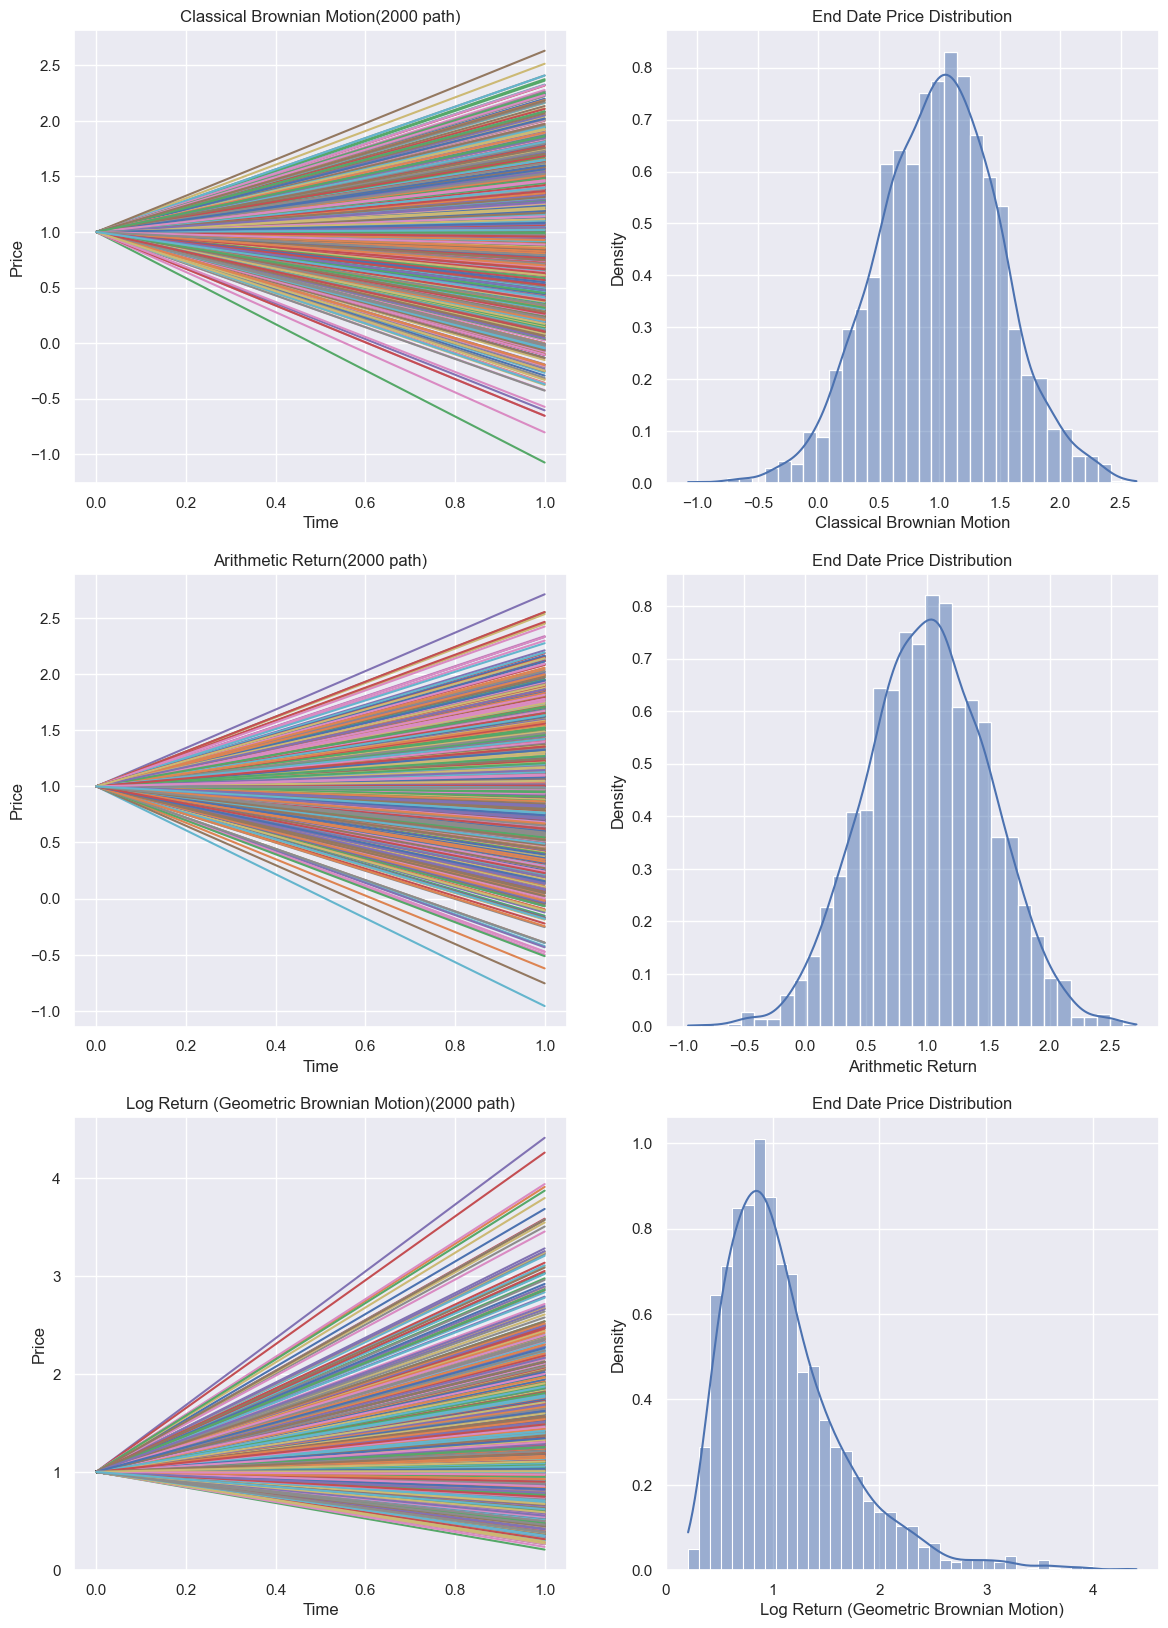

In [54]:
simulate_price(1,path_num=2000,time_periods=1).comparison(std=0.5)

                            Classical Brownian Motion Arithmetic Return  \
Mean                                         1.009708          0.994675   
Expected Mean                                       1               NaN   
Standard Deviation                           0.503614          0.536748   
Expected Standard Deviation                       0.5               NaN   

                            Log Return (Geometric Brownian Motion)  
Mean                                                      1.134657  
Expected Mean                                             1.133148  
Standard Deviation                                        0.621235  
Expected Standard Deviation                               0.603901  


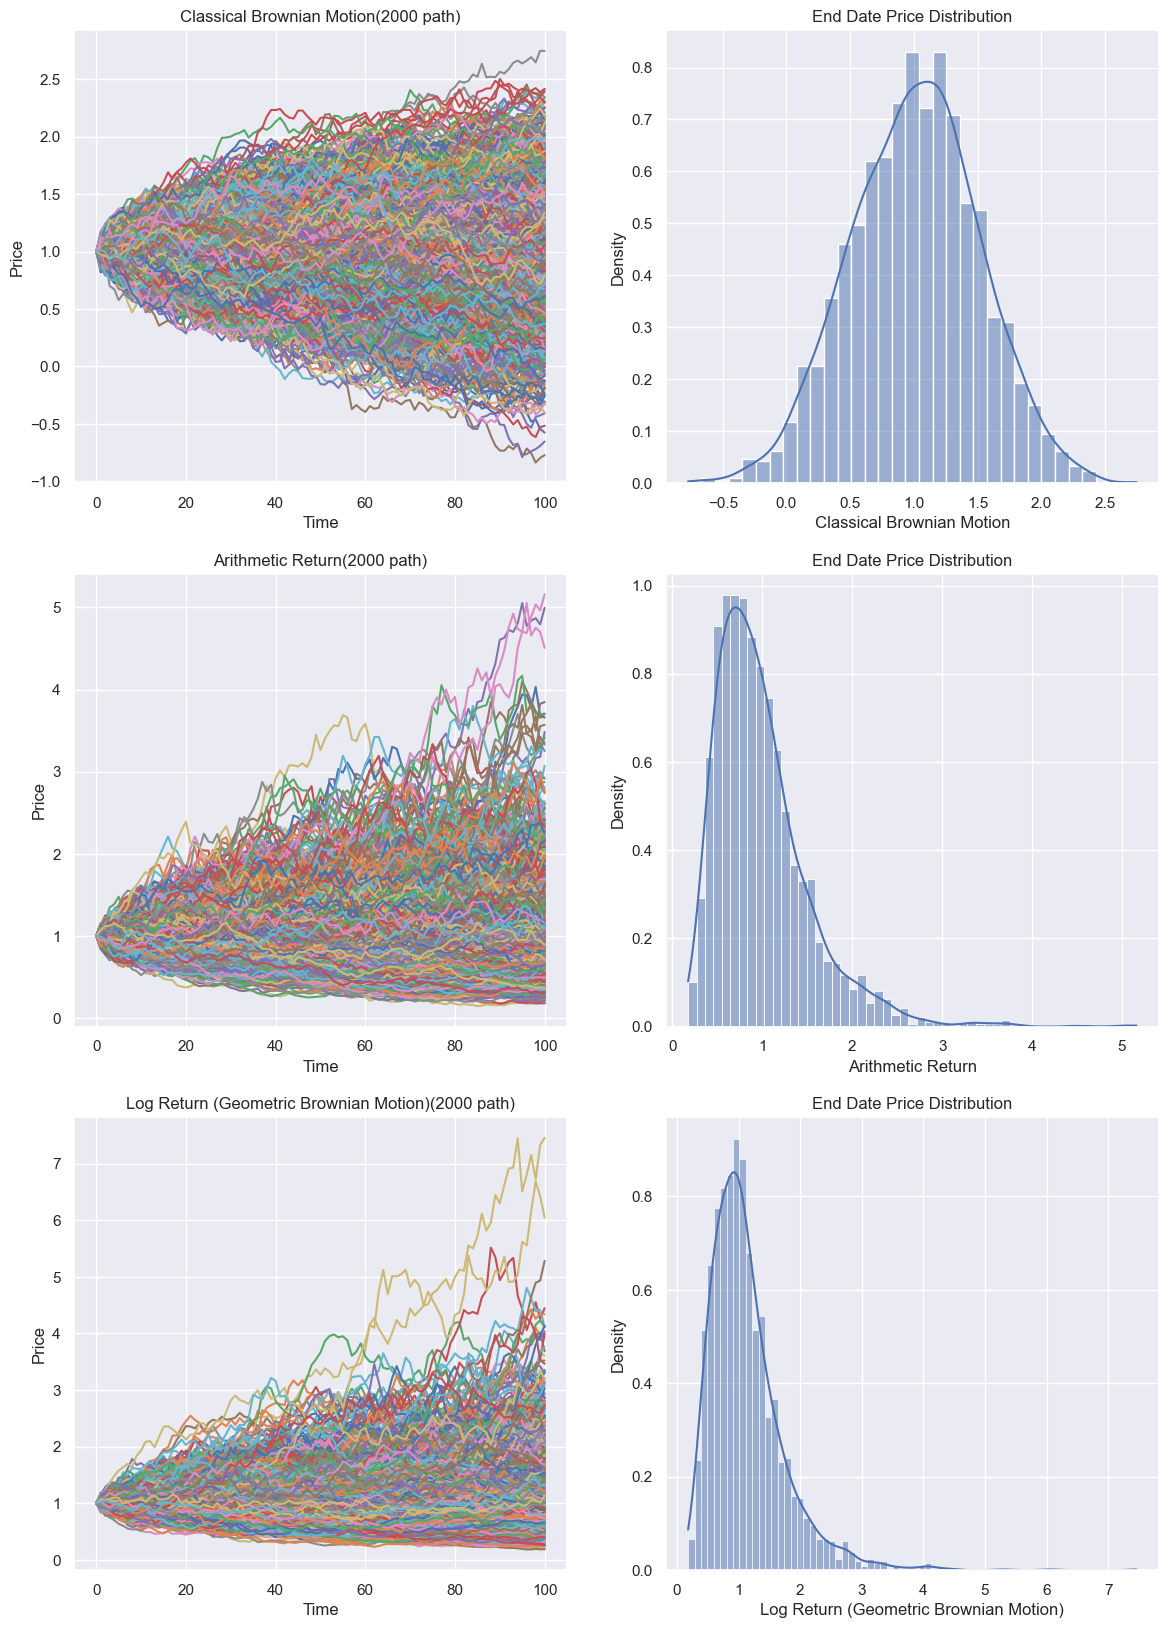

In [55]:
simulate_price(1,path_num=2000,time_periods=100).comparison(std=0.05)

# Problem 2

Implement a function similar to the “return_calculate()” in this week’s code. Allow the user to specify the method of return calculation.

Use DailyPrices.csv. Calculate the arithmetic returns for all prices.

Remove the mean from the series so that the mean(META)=0.

Calculate VaR:
1. Using a normal distribution.
2. Using a normal distribution with an Exponentially Weighted variance $\lambda$ = 0. 94
3. Using a MLE fitted T distribution.
4. Using a fitted AR(1) model.
5. Using a Historic Simulation.

Compare the 5 values

In [2]:
def return_calculate(Price,option="DISCRETE",rm_means=True):
    '''
        Provide two ways to calculate the return from Price dataframce.
    '''
    # calculate the log normal return 
    if option == 'CONTINUOUS':
        returns = np.log(df/df.shift()).dropna()
    # calculate the discrete return 
    elif  option == 'DISCRETE':
        returns = df.pct_change().dropna()
    # other undefined option will cause error
    else:
        raise Exception("Unknown Option!")
    # remove mean from the returns
    return returns if rm_means==False else returns-returns.mean()
    

In [57]:
class T_fitter:
    '''T distribution MEL fitter'''
    def ll_t(self,parameter,x):
        # log likelihood 
        ll=np.sum(stats.t.logpdf(x=x,df=parameter[0],loc=0,scale=parameter[1])) # assume mean to be 0
        return -ll

    def MLE(self,x):
        cons=[ {'type':'ineq', 'fun':lambda x:x[1]} ] # standard deviation is non-negative
        parameter = np.array([x.size-1,1])
        MLE = minimize(self.ll_t, parameter, args = x, constraints = cons) # MLE
        return MLE.x

In [56]:
def simulate_AR1_process(alpha,beta,sigma,sample_size):
    # Simulate AR(1) process
    ''' AR(1)
        y_t = alpha + beta*y_t-1 + e, e ~ N(0,sigma2)
    '''
    x0=alpha/(1-beta)
    x=np.zeros(sample_size+1)
    x[0]=x0
    eps=stats.norm.rvs(size=sample_size,scale=sigma)
    for i in range(sample_size):
        x[i+1]=alpha+beta*x[i]+eps[i]
    return x

In [91]:
class VaR:
    '''Calculate the VaR of 1D array or dataframe of return due to specific distribution'''
    def __init__(self,data,option="Absolute",alpha=0.05):
        # Absolute Value at risk or Relative Value at risk
        if option != "Absolute" and option != "Relative":
            raise Exception('Unknown option!')
        self.__option=option
        # 1-alpha is confidence level
        self.__alpha=alpha
        # returns data
        self.__data=data

    def normal(self,option='Normal'):
        '''Assume returns follow normal distribution'''
        # assume mean to be 0
        mu=0
        # calculate the standard deviation
        if option == 'Normal': # use normal standard deviation
            std=self.__data.std() 
        elif option == 'EWMA': # use EW standard deviation
            model=project3.EWMA(META,0.94) # assume lambda = 0.94
            std=np.sqrt(model.cov_mat)
        else: 
            raise Exception('Unknown option!')
        # plot the normal Probability density function
        max_val=self.__data.max()
        min_val=self.__data.min()
        x=np.linspace(min_val,max_val,1000)
        y=stats.norm.pdf(x=x,loc=mu,scale=std)
        plt.plot(x,y,color='brown')
        # plot the return data & its empirical kde
        sns.histplot(self.__data,kde=True,stat='density')
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        # plot the VaR
        plt.axvline(-VaR,color='#FF6347')
        return VaR
        
    def T_dist(self):
        para=T_fitter().MLE(self.__data)
        mu=0 # assume mean to be 0
        df=para[0] # degree of freedom of T distribution
        std=para[1] # standard deviation
        # plot the T Probability density function
        max_val=self.__data.max()
        min_val=self.__data.min()
        x=np.linspace(min_val,max_val,1000)
        y=stats.t.pdf(x=x,df=df,loc=mu,scale=std)
        plt.plot(x,y,color='brown')
        # plot the return data & its empirical kde
        sns.histplot(self.__data,kde=True,stat='density')
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        # plot the VaR
        plt.axvline(-VaR,color='#FF6347')
        return VaR

    def AR_1(self):
        # Use AR(1) fitter to find the best cofficience
        mod = sm.tsa.arima.ARIMA(META.values, order=(1, 0, 0))
        res = mod.fit()
        const=0 # constant number
        ar_L1=res.params[1] # cofficience of Lag 1
        sigma2=res.params[2] # variance of error term

        # AR(1) is also normal
        mu=0
        std=np.sqrt(sigma2/(1-ar_L1))
        # plot the AR(1) Probability density function
        max_val=self.__data.max()
        min_val=self.__data.min()
        x=np.linspace(min_val,max_val,1000)
        y=stats.norm.pdf(x=x,loc=mu,scale=std)
        plt.plot(x,y,color='brown')
        # plot the return data & its empirical kde
        sns.histplot(self.__data,kde=True,stat='density')
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        # plot the VaR
        plt.axvline(-VaR,color='#FF6347')
        return VaR
    
    def historical_simulation(self,path_num,alpha):
        size=self.__data.shape[0]
        rt=pd.DataFrame(np.random.choice(self.__data.values,size=[size,path_num]))
        rt=rt.mean(axis=1)
        rt.sort()
        # plot the AR(1) Probability density function
        max_val=self.__data.max()
        min_val=self.__data.min()
        x=np.linspace(min_val,max_val,size)
        y=rt
        plt.plot(x,y,color='brown')
        # plot the return data & its empirical kde
        sns.histplot(self.__data,kde=True,stat='density')
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-np.quantile(self.__alpha,alpha)
        else:
            VaR=rt.mean()-np.quantile(self.__alpha,alpha)
        # plot the VaR
        plt.axvline(-VaR,color='#FF6347')
        return VaR
        

In [18]:
df=pd.read_csv('DailyPrices.csv',index_col='Date')

In [19]:
rt=return_calculate(df)
META=rt['META']

In [90]:
a=np.random.choice(10,[3,5])
a.mean(axis=1)

array([2.8, 6.4, 5.8])

In [92]:
VaR(META).historical_simulation(2000,0.05)

TypeError: __init__() missing 1 required positional argument: 'rt_option'

0.06560156967533284

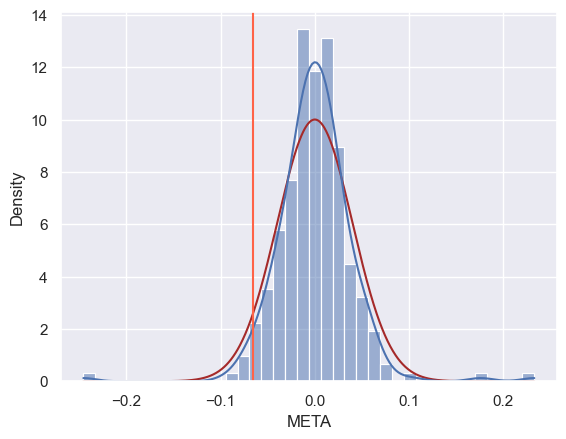

In [48]:
VaR(META).normal()

0.09138525104032248

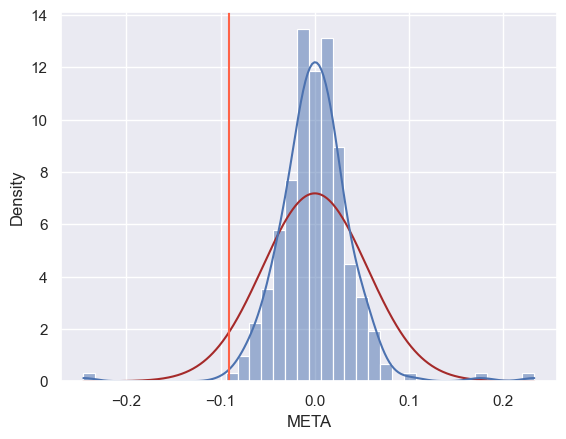

In [47]:
VaR(META).normal('EWMA')

/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


0.05725632756853766

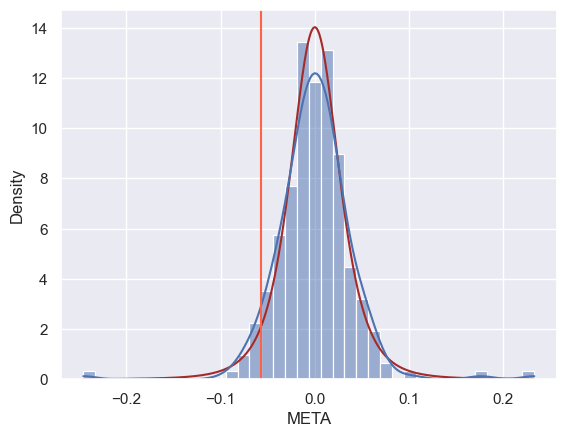

In [49]:
VaR(META).T_dist()

0.06570519171558095

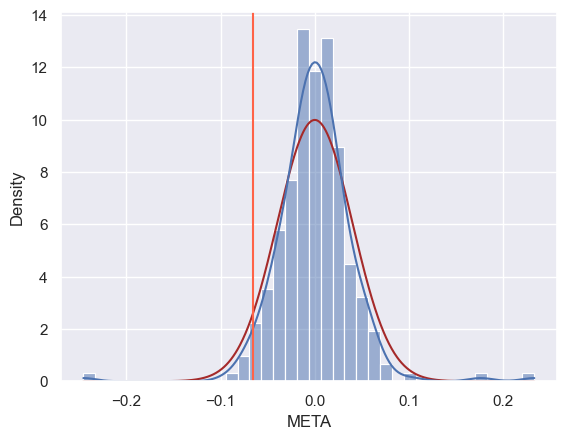

In [73]:
VaR(META).AR_1()

In [ ]:
        if self.__option=="Absolute":
            VaR=-np.quantile(sample,self.__alpha)
        else:
            VaR=sample.mean()-np.quantile(sample,self.__alpha)
        return VaR

In [50]:
        sns.histplot(sample,kde=True,ax=ax)
        sns.histplot(sample[:round(size*self.__alpha)],color='#FF6347',ax=ax)
        plt.axvline(-VaR,color='#FF6347')

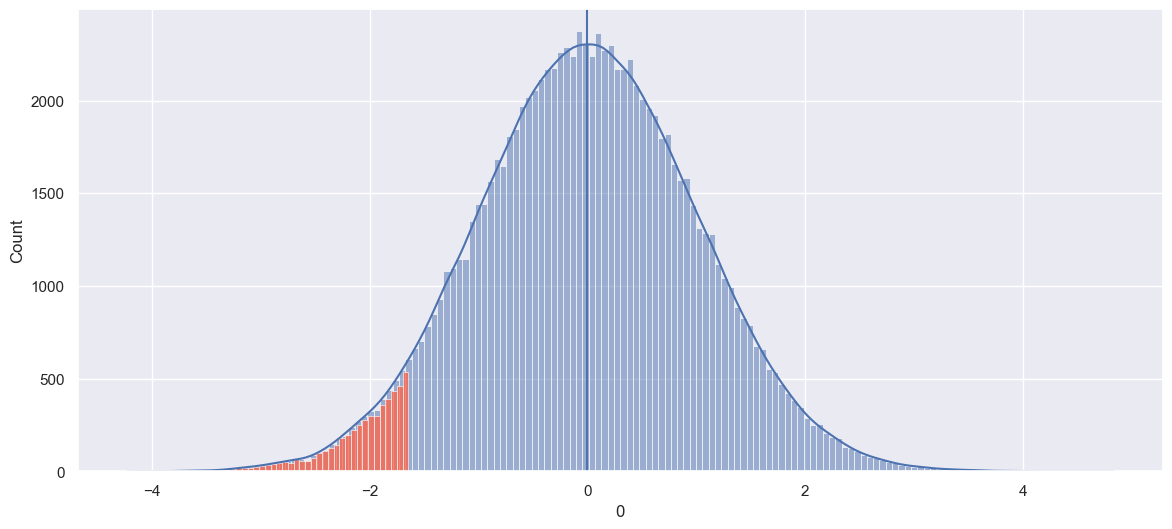

In [101]:

fig, ax = plt.subplots(1,figsize=(14,6))
sns.histplot(sample,x=0,kde=True,ax=None)
sns.histplot(sample[:int(100000*0.05)],x=0,color='#FF6347',ax=None)
plt.axvline()

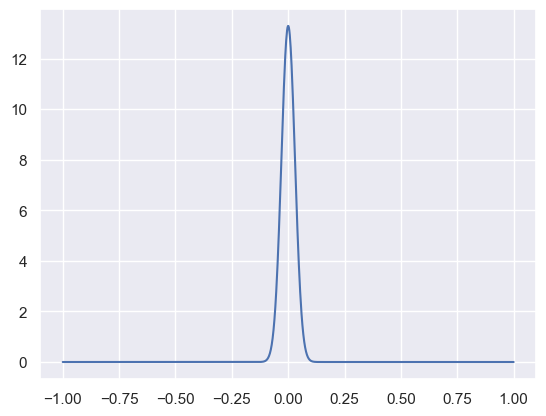

In [140]:
max_val=1
min_val=-1
x=np.linspace(min_val,max_val,1000)
y=stats.norm.pdf(x=x,loc=0,scale=0.03)
plt.plot(x,y)

In [7]:
len((1,2))

2

In [105]:
np.quantile(sample,0.05)

-1.643653785412358

In [ ]:
        fig, ax = plt.subplots(1,2,figsize=(14,20))
        if self.__rt_option='DISCRETE':
            Price=initial_price * (1+rt).cumprod()
            Price.plot(ax=ax[0][0],legend=False,xlabel='Time',ylabel='Price',title="Arithmetic Return({} path)".format(path_num))
        elif self.__rt_option='CONTINUOUS':
            Price=initial_price * np.exp(rt.cumsum())
            Price.plot(ax=ax[0][0],legend=False,xlabel='Time',ylabel='Price',title="Log Return (Geometric Brownian Motion)({} path)".format(path_num)
        else:
            raise Exception("Unknow option!")